In [1]:
import numpy as np
import sklearn.gaussian_process as gp
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState
from scipy.stats import norm

from util.defs import *
from bayesian_optimizers.gpr_optimizer import GPROptimizer
from acquisition.acquisition_functions import ProbabilityOfImprovement, ExpectedImprovement
from acquisition.acquisition_optimizers import RandomAcquisitionOpt, ConstrainedAcquisitionOpt, random_x_sample
sns.set_style("darkgrid")

In [2]:
rand = RandomState(seed=54321)
# rand = RandomState()

# Define functions

In [3]:
def objective(X, noise=0.1):
    # This is a stand-in for a real objective
    noise = rand.normal(loc=0, scale=noise, size=X.shape)
    # want to do a minimization, so negate & translate up by 1.5
    return -(X**2 * np.sin(5 * np.pi * X)**6) + 1.5 + noise

    # "Real" objective involves training & evaluation a model.
    # For example, with a classifier, we would do this:
    
    # Build/train model using hyperparameters X
    
    # Evaluate model (get accuracy)
    
    # Return 1 - accuracy (objective is to be as accurate as possible)


def plot_real_sample_vs_surrogate_surface(X, y, model):
    _, ax = plt.subplots()
    
    X_samp = np.arange(0, 1, 0.001)[:, np.newaxis]
    y_samp = model.predict(X_samp)
    sns.scatterplot(X[:, 0], y[:, 0], ax=ax)
    sns.lineplot(X_samp[:, 0], y_samp[:, 0], ax=ax, color="black")
    
    return ax


def plot_objective(X, y):
    _, ax = plt.subplots()
    sns.lineplot(X[:, 0], y[:, 0], ax=ax, color="black")
    return ax

In [4]:
bounds = np.array([
    [0.0, 1.0],
])
p_types = [ParamType.Cont]

# take a random sample of X values
X = random_x_sample(bounds, p_types, samples=100, rand=rand)
# plug the random sample into the objective
y = objective(X, noise=0)

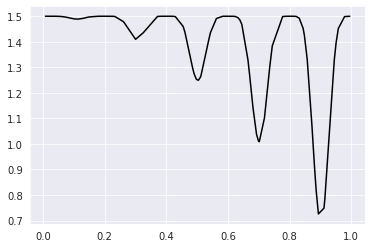

In [5]:
ax = plot_objective(X, y)
plt.show()

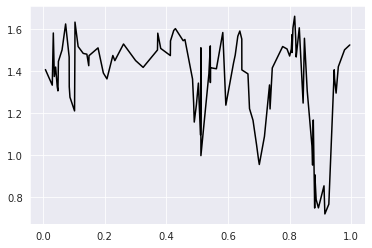

In [6]:
y = objective(X)
ax = plot_objective(X, y)
plt.show()

# Define the GPR that will be used in the optimizer

In [7]:
kernel = gp.kernels.RBF()
# Defining the scale parameter here is cheating a bit (since used the same value when generating the data)
gpr = gp.GaussianProcessRegressor(kernel, 
                                  alpha=np.abs(rand.normal(scale=.01)),
                                  n_restarts_optimizer=10, 
                                  random_state=rand)

# Select acquisition function, acquisition function optimizer, and define GPR optimizer

In [8]:
# acquisition = ProbabilityOfImprovement()
acquisition = ExpectedImprovement()
# opt_acquisition = RandomAcquisitionOpt(gpr, acquisition, rand)
opt_acquisition = ConstrainedAcquisitionOpt(gpr, acquisition, rand)

gpr_opt = GPROptimizer(gpr, opt_acquisition, objective, bounds, p_types, rand, initial_samples=5, fit=True)

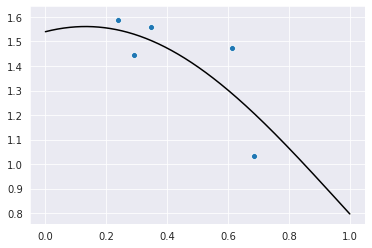

In [9]:
ax = plot_real_sample_vs_surrogate_surface(gpr_opt.X, gpr_opt.y, gpr_opt.gpr)
plt.show()

# Perform Bayesian optimization

In [10]:
res = gpr_opt.optimize(25)

{'argmin': 27, 'minimizer': array([0.89568073]), 'minimum': array([0.49518433])}


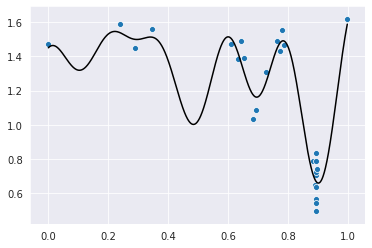

In [11]:
plot_real_sample_vs_surrogate_surface(gpr_opt.X, gpr_opt.y, gpr_opt.gpr)
print(res)